In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
tickers = list(prices.columns[:-4])+['현금']

In [4]:
oecd = pd.read_csv("data/OECD.csv", index_col=0, parse_dates=True).rename_axis("Date")
oecd_MOM = oecd.resample('D').first().fillna(method='ffill') #전월비
target_weights1 = pd.DataFrame(np.where(oecd_MOM > 1, 1, 0), index=oecd_MOM.index)
target_weights1['현금'] = 1 - target_weights1
target_weights1.columns = ['base1', '현금'] # 'base1'은 위의 전략과 이름을 맞추어야 한다. '현금'도 prices의 컬럼이름과 맞추어야 한다.


kbase1 = bt.Strategy('kbase1',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=1, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights1, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [5]:
dd = pd.read_csv('월별투자자별매매동향대신.csv', index_col=0, parse_dates=True)
외국인수급 = dd.loc['2001':'2021-08', '외국인'].copy().to_frame()
외국인수급.columns = ['kospi']
외국인수급 = 외국인수급.resample('MS').first().shift(1)
외국인수급 = 외국인수급 - 외국인수급.min()
외국인수급['1m'] = 외국인수급['kospi'].pct_change(1)
외국인수급['2m'] = 외국인수급['kospi'].pct_change(1).shift(1)
외국인수급['3m'] = 외국인수급['kospi'].pct_change(1).shift(2)
연속3개월 = ((외국인수급['3m'] > 0) & (외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속2개월 = ((외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속1개월 = (외국인수급['1m'] > 0)
target_weights2 = pd.DataFrame(np.where(연속3개월, 1.0,
                                        np.where(연속2개월, 0.66,
                                                np.where(연속1개월, 0.33, 0))),
                             index=외국인수급.index, columns=['base2'])
target_weights2['현금'] = 1.0 - target_weights2
target_weights2.columns = ['base2', '현금']

kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights2, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [6]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]

c='코스피200'
target_weights3 = pd.DataFrame()
target_weights3['base3'] = prices[c].rolling(365).apply(AMS)
target_weights3['현금'] = 1.0 - target_weights3
target_weights3.columns = ['base3', '현금']

kbase3 = bt.Strategy(
    'kbase3',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights3, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [7]:
kbase123 = bt.Strategy(
    'kbase123',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
#         bt.algos.PrintDate(),
        bt.algos.SelectAll(),
    #   bt.algos.SelectThese(tickers),
    # 변동성 제어한 비중에 대한 dataframe
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children = [kbase1, kbase2, kbase3]
)

In [8]:
prices_dollar = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
# FIXME 달러자산으로 AMS를 하는게 맞는가 아니면 원화자산에 AMS를 하는게 맞는가?
target_weights4 = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights4[c] = prices_dollar[c].rolling(365).apply(AMS)
target_weights4 = target_weights4*0.5
target_weights4['달러'] = 1.0 - target_weights4.sum(axis=1)

나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights4),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [9]:
통합 = bt.Strategy(
    '통합',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        # bt.algos.PrintDate(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()],
)

In [10]:
bt_kbase1 = bt.Backtest(kbase1, prices)
bt_kbase2 = bt.Backtest(kbase2, prices)
bt_kbase3 = bt.Backtest(kbase3, prices)

bt_kbase123 = bt.Backtest(kbase123, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS, prices_dollar)

r1 = bt.run(bt_나스닥다우동일비중AMS)
r2 = bt.run(bt_kbase123)

# r = bt.run(bt_kbase1, bt_kbase2, bt_kbase3)
# rr = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123)

합성지수를 만든다.

In [11]:
data = bt.merge(r1['나스닥다우동일비중AMS'].prices, r2['kbase123'].prices)
data.head()

,나스닥다우동일비중AMS,kbase123
2001-01-01,100.000,100.000
2001-01-02,100.000,100.000
2001-01-03,100.000,100.000
2001-01-04,100.000,100.000
2001-01-05,100.000,100.000


In [12]:
bt_통합 = bt.Backtest(통합, data)
r3 = bt.run(bt_통합)

In [13]:
r3.set_date_range("2002-02-01")
r3.display()

Stat                 통합
-------------------  ----------
Start                2002-02-01
End                  2020-07-02
Risk-free rate       0.00%

Total Return         619.99%
Daily Sharpe         0.88
Daily Sortino        1.38
CAGR                 11.32%
Max Drawdown         -20.96%
Calmar Ratio         0.54

MTD                  1.84%
3m                   13.93%
6m                   7.94%
YTD                  7.52%
1Y                   12.30%
3Y (ann.)            7.67%
5Y (ann.)            9.79%
10Y (ann.)           11.24%
Since Incep. (ann.)  11.32%

Daily Sharpe         0.88
Daily Sortino        1.38
Daily Mean (ann.)    7.79%
Daily Vol (ann.)     8.87%
Daily Skew           0.05
Daily Kurt           11.15
Best Day             6.50%
Worst Day            -4.64%

Monthly Sharpe       1.05
Monthly Sortino      2.11
Monthly Mean (ann.)  11.11%
Monthly Vol (ann.)   10.58%
Monthly Skew         0.21
Monthly Kurt         2.01
Best Month           14.14%
Worst Month          -7.88%

Yearly 

In [14]:
r_all = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123, bt_나스닥다우동일비중AMS, bt_통합)
r_all.set_date_range("2002-02-01")
r_all.display()

Stat                 kbase1      kbase2      kbase3      kbase123    나스닥다우동일비중AMS    통합
-------------------  ----------  ----------  ----------  ----------  -----------------------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01               2002-02-01
End                  2020-07-02  2020-07-02  2020-07-02  2020-07-02  2020-07-02               2020-07-02
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%                    0.00%

Total Return         5821.11%    437.70%     858.74%     1477.59%    187.02%                  619.99%
Daily Sharpe         0.87        0.58        0.66        0.85        0.40                     0.88
Daily Sortino        1.37        0.89        1.01        1.35        0.61                     1.38
CAGR                 24.81%      9.56%       13.06%      16.16%      5.89%                    11.32%
Max Drawdown         -29.47%     -25.76%     -40.90%     -28.83%     -22.90%                  -

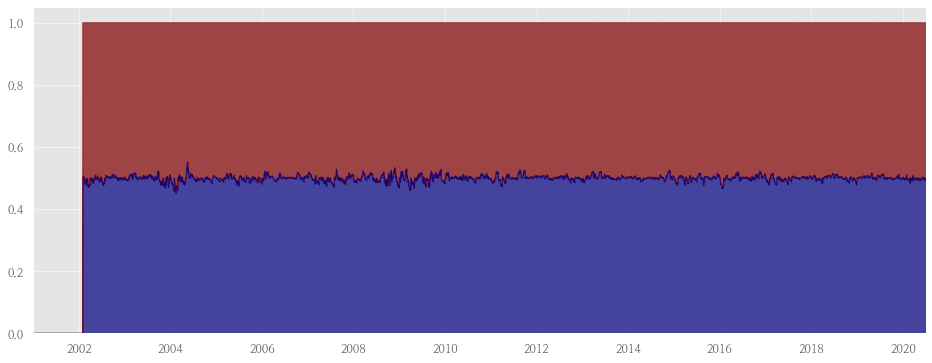

In [15]:
r_all.get_security_weights('통합').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

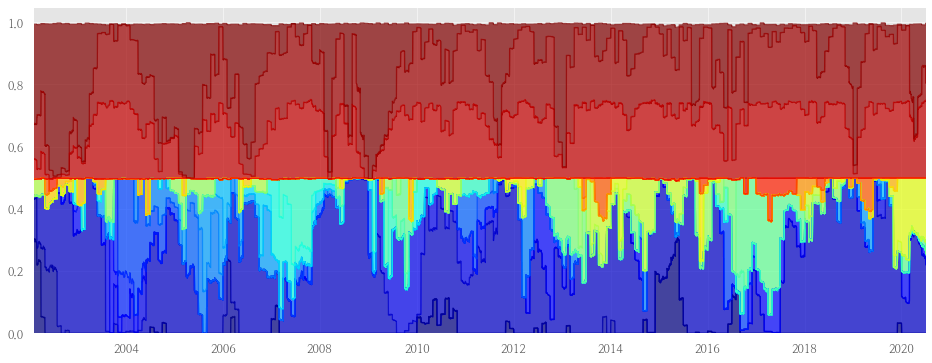

In [16]:
dollar_assets_weights = r1.get_security_weights()*0.5
kbase123_weights = r2.get_security_weights()*0.5
security_weights = bt.merge(kbase123_weights, dollar_assets_weights)
security_weights = security_weights['2002-02-01':]
security_weights.plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

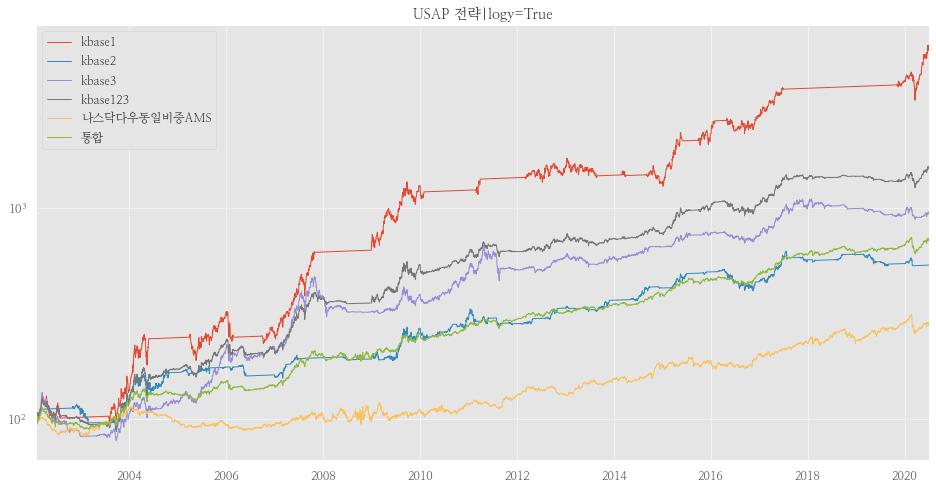

In [17]:
ax = r_all.plot(figsize=(16,8), logy=True, title="USAP 전략|logy=True");
plt.legend(loc="upper left");

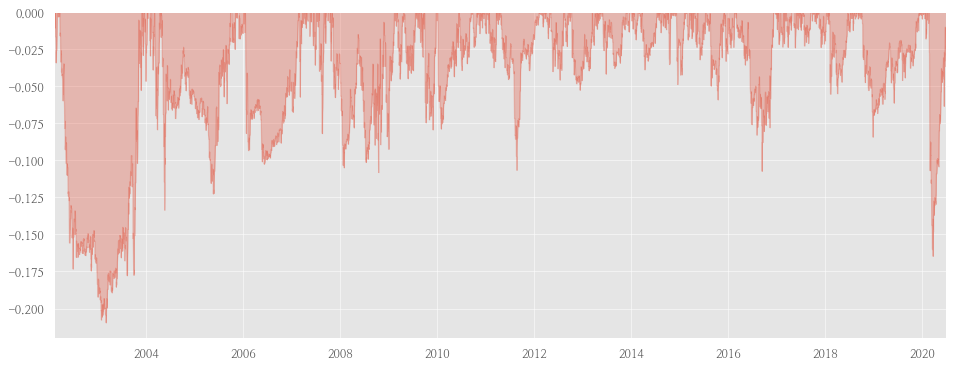

In [18]:
r_all['통합'].prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

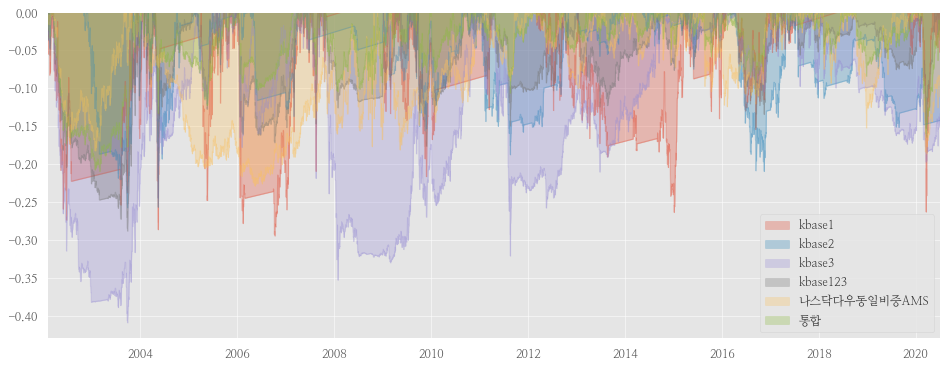

In [19]:
r_all.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          619.99%     1,477.59%
CAGR﹪                     11.31%      16.15%

Sharpe                     0.88        0.85
Smart Sharpe               0.87        0.84
Sortino                    1.28        1.27
Smart Sortino              1.26        1.25
Sortino/√2                 0.91        0.9
Smart Sortino/√2           0.89        0.89
Omega                      1.21        1.21

Max Drawdown               -20.96%     -28.83%
Longest DD Days            621         905
Volatility (ann.)          8.87%       13.11%
R^2                        0.58        0.58
Calmar                     0.54        0.56
Skew                       0.05        0.24
Kurtosis                   11.15      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2002-03-20,2003-03-03,2003-12-01,621,-20.959,-20.475
2,2020-02-21,2020-03-23,2020-07-02,132,-16.475,-15.928
3,2004-04-23,2004-05-17,2005-09-26,521,-13.359,-11.974
4,2007-10-30,2008-10-15,2009-02-11,470,-10.816,-10.103
5,2016-03-03,2016-09-12,2016-12-08,280,-10.737,-8.783


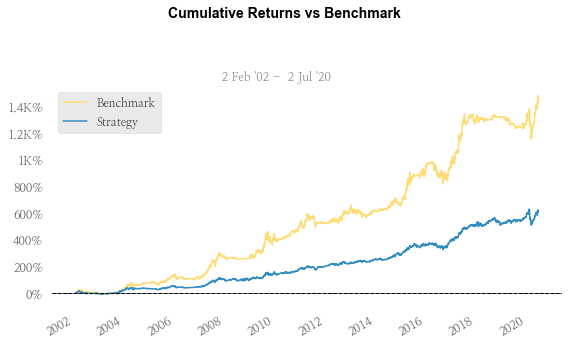

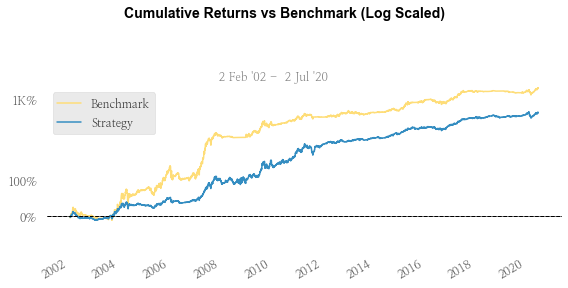

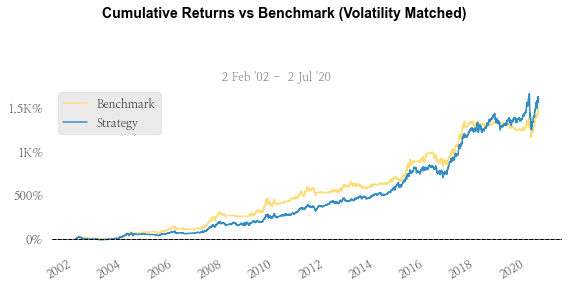

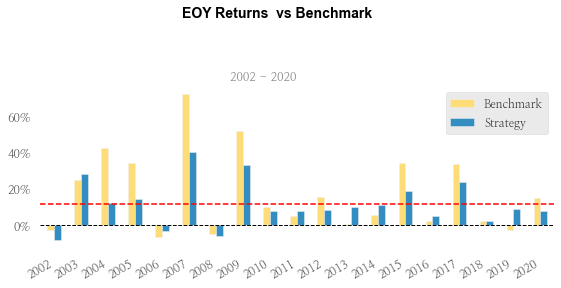

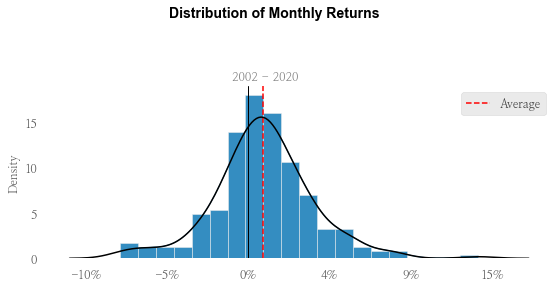

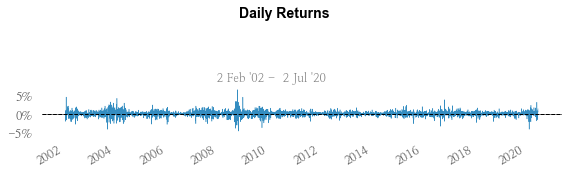

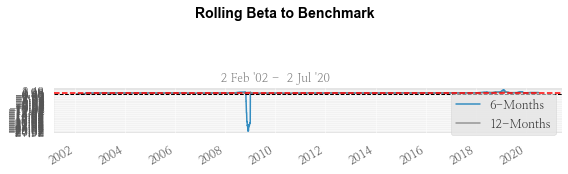

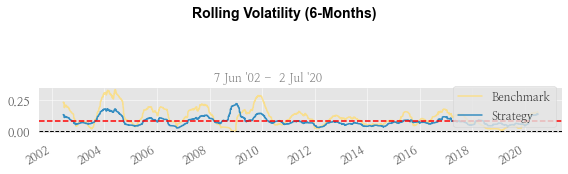

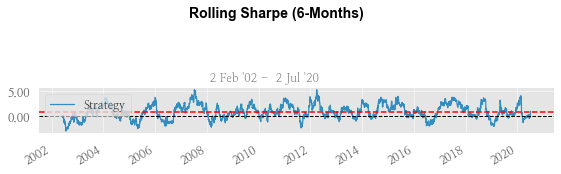

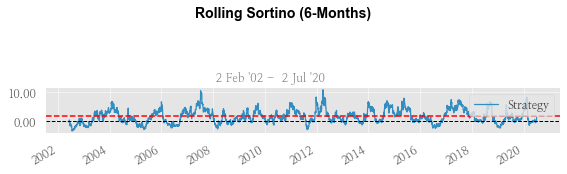

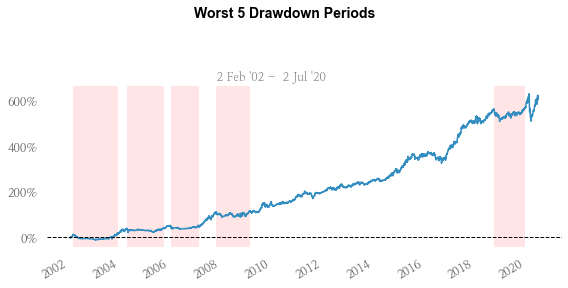

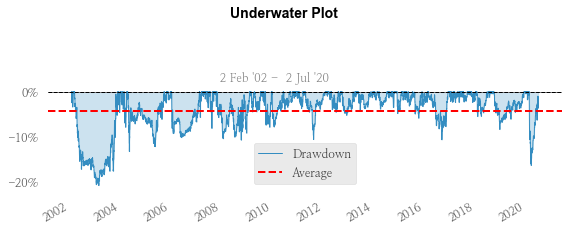

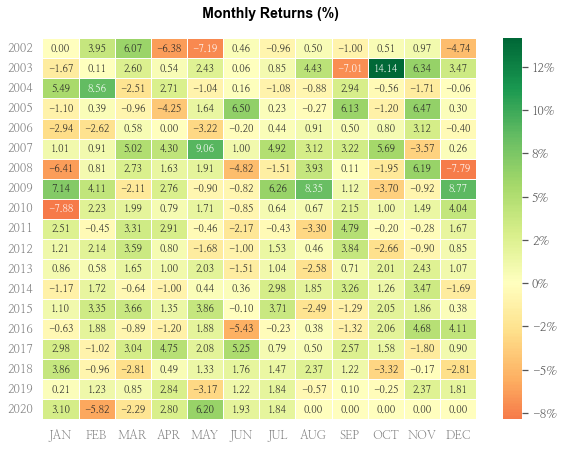

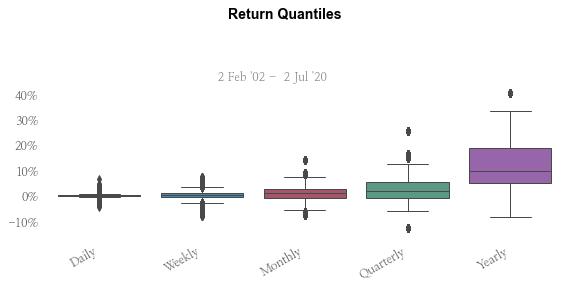

In [20]:
qs.reports.full(r_all['통합'].prices.to_returns().dropna(), 
                r_all['kbase123'].prices.to_returns().dropna())